# CESM-LE analysis
### Looks and changes in Fire risk over time
 - reading in ensemble of data from CESM2_LENS
 - here, looking at daily TBOT, RH, & precip
 - calculations with 36 dask workers from casper tend to spill to disk
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [3]:
%load_ext autoreload
%autoreload 2
import glob
import os

import cftime
import dask
import FWI_Wang2015 as fwi  # Jackie's python script
import matplotlib
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from tqdm.auto import tqdm

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### run this cell to check if you have LENS2 read access:

In [4]:
samplefile = (
    '/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'
    + 'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc'
)
cmd = 'stat ' + samplefile
if os.system(cmd) != 0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [5]:
# For use on Casper: ONLY RUN THIS CELL ONCE
# note you may need to change the project number
# Anderson recommended "Reduce the number of dask-workers (from 36 to 18)
#    to allow dask to allocate more memory to each worker"
ncores = 18
nmem = str(int(375 * ncores / ncores)) + 'GB'
from dask.distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster(
    cores=ncores,
    processes=ncores,
    memory=nmem,
    #                      project='P93300641',
    walltime='1:00:00',
    extra=["--lifetime", "55m", "--lifetime-stagger", "4m"],
)
# cluster.scale(ncores)
cluster.adapt(minimum_jobs=1, maximum_jobs=3)
client = Client(cluster)

/glade/work/abanihi/opt/miniconda/envs/lens-py/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32887 instead
  http_address["port"], self.http_server.port


In [6]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
cluster

# If not running, check the following on command line
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel 6444926`

### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [7]:
def get_file(ee, model, field, component, yr):
    ''' Returns a given field from ensemble number ee for either CESM1 or CESM2'''
    if model == 'CESM1':
        topdir = (
            '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/' + 'lnd/proc/tseries/monthly/'
        )
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1 + np.arange(35)) + list(101 + np.arange(7))
        nn = lenskey[ee]
        ff = glob.glob(topdir + field + '/' + matchme + str(nn).zfill(3) + '*.nc')[0]
    else:
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        if yr <= 2014:
            mlist = sorted(
                glob.glob(topdir + '*BHISTcmip6.f09_g17.LE2-12*')
            )  # not all ensembles have daily data
        else:
            mlist = sorted(glob.glob(topdir + '*BSSP370cmip6.f09_g17.LE2-12*'))  # hack to get SSPs
        mm = mlist[ee]
        atm = '/atm/proc/tseries/day_1/'
        lnd = '/lnd/proc/tseries/day_1/'
        firstyear = 10 * int(yr / 10)
        if yr >= 2015:  # Beause SSPs are 2015-2024...
            firstyear = 10 * int(yr / 10) + 5
        yy = '.' + str(firstyear) + '0101-' + str(firstyear + 9) + '1231.'

        if yr > 2009:
            if yr < 2014:
                yy = '.20100101-20141231.'
        if yr >= 2095:
            yy = '.20950101-21001231.'
        if component == 'lnd':
            ff = glob.glob(mm + lnd + '*.h5.' + field + yy + '*')[0]
        if component == 'atm':
            ff = glob.glob(mm + atm + '*.h1.' + field + yy + '*')[0]
    return ff

In [8]:
def all_files(model, field, firstyear, component, nens):
    ''' Returns all files for either CESM1 or CESM2, starting at firstyear'''
    if model == 'CESM1':
        files = [get_file(ee, 'CESM1', field, component, 0) for ee in range(nens)]
    else:
        if firstyear <= 2014:
            yrs = [*np.arange(firstyear, 2009, 10), 2010]
        if firstyear > 2014:
            yrs = [*np.arange((firstyear), 2094, 10), 2095]

        files = [[get_file(ee, 'CESM2', field, component, yr) for yr in yrs] for ee in range(nens)]
        # print(files)
    return files

In [9]:
def preprocess(ds):
    variables = {"RAIN", "SNOW", "TREFHT", "RHREFHT", "WSPDSRFAV", "TREFHTMX", "PPT"}
    x = list(set(ds.data_vars).difference(variables))
    for v in x:
        ds = ds.set_coords(v)
        ds[v].load()
    return ds

In [10]:
def get_daily(model, fields, firstyear, component, nens, chunks={'time': 500}):
    first = True

    for field in fields:
        # find the appropriate files
        files = all_files(model, field, firstyear, component, nens)

        # instantiation steps only required once
        if first:
            first = False
            # set up ensemble dimensions
            ensdim = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
            ensdim.attrs['long_name'] = 'ensemble number'
            concat_dim = {'CESM1': ensdim, 'CESM2': [ensdim, 'time']}

            # instantiate ds
            if model == 'CESM2':
                # LENS2 is split by decade, take only 1 copy of landfrac,area, etc.
                # add chunks for time
                ds = xr.open_mfdataset(
                    files[0],
                    combine='by_coords',
                    parallel=True,
                    chunks=chunks,
                    preprocess=preprocess,
                )
                tmp = xr.open_dataset(files[0][0], chunks=chunks)
                tmp = preprocess(tmp)
                for thisvar in tmp.data_vars:
                    if 'time' not in tmp[thisvar].coords:
                        ds[thisvar] = tmp[thisvar]
            else:
                ds = xr.open_dataset(files[0], chunks=chunks)
                ds = preprocess(ds)

        tmp = xr.open_mfdataset(
            files,
            combine='nested',
            parallel=True,
            concat_dim=concat_dim[model],
            chunks=chunks,
            preprocess=preprocess,
        )
        ds[field] = tmp[field]

    if component == 'lnd':
        ds['landarea'] = ds['area'] * ds['landfrac']
        ds['landarea'].name = 'landarea'
        ds['landarea'].attrs['units'] = 'km2'

    ndays = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] = xr.cftime_range(str(yr0), periods=ndays, freq='D')
    # Deepak recommended this:
    # ds.sel(time=slice(str(firstyear), None))
    # instead of this:
    ix = ds['time.year'] >= firstyear

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        return ds.isel(time=ix)

In [11]:
def month_wts(nyears):
    days_pm = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    return xr.DataArray(np.tile(days_pm, nyears), dims='time')

# Start editing here:
 - note: you don't have to %%time things
     - just wanted to give a sense of how long various steps take for me

### Actually read the data in here

In [12]:
%%time

lnd_vars = ['RAIN', 'SNOW']
model = 'CESM2'
fyHIST = 2010
fySSP = 2095
component = 'lnd'
nens = 5  # read in 10 ensemble members for now
ds = get_daily(model, lnd_vars, fyHIST, component, nens)
dsSSP = get_daily(model, lnd_vars, fySSP, component, nens)

atm_vars = ['TREFHT', 'RHREFHT', 'WSPDSRFAV', 'TREFHTMX']  #
component = 'atm'
ds_atm = get_daily(model, atm_vars, fyHIST, component, nens)
ds_atmSSP = get_daily(model, atm_vars, fySSP, component, nens)

CPU times: user 8.32 s, sys: 1.02 s, total: 9.34 s
Wall time: 45.8 s


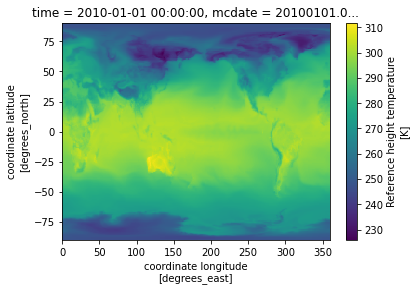

In [13]:
# force coordinate variables to match
ds_atm['lat'] = ds['lat']
ds_atm['lon'] = ds['lon']
ds_atmSSP['lat'] = dsSSP['lat']
ds_atmSSP['lon'] = dsSSP['lon']

for i in range(len(atm_vars)):
    ds[atm_vars[i]] = ds_atm[atm_vars[i]]
    dsSSP[atm_vars[i]] = ds_atmSSP[atm_vars[i]]

ds[atm_vars[0]].isel(ens=0, time=0).plot();

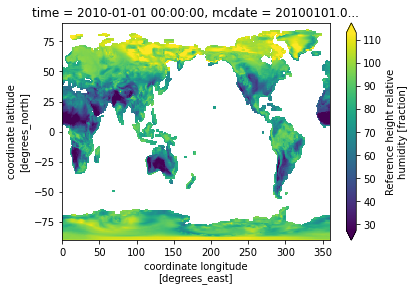

In [14]:
# sum rain + snow for precip.
s2d = 3600 * 24  # convert from sec to day
ds['PPT'] = (ds['RAIN'] + ds['SNOW']) * s2d
ds.PPT.attrs['units'] = 'mm/d'
ds.PPT.attrs['long_name'] = 'Total Precip.'

dsSSP['PPT'] = (dsSSP['RAIN'] + dsSSP['SNOW']) * s2d
dsSSP.PPT.attrs['units'] = 'mm/d'
dsSSP.PPT.attrs['long_name'] = 'Total Precip'

# mask out oceans for temp and RH
ds = ds.where(ds['PPT'].max(['time', 'ens']) > 0.0)
dsSSP = dsSSP.where(dsSSP['PPT'].max(['time', 'ens']) > 0.0)
ds['RHREFHT'].isel(time=0, ens=0).plot(robust=True);

In [15]:
ds

<xarray.Dataset>
Dimensions:       (ens: 5, hist_interval: 2, lat: 192, levdcmp: 25, levgrnd: 25, levlak: 10, lon: 288, time: 1826)
Coordinates:
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat           (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    area          (lat, lon) float32 29.95 29.95 29.95 29.95 ... nan nan nan nan
    landfrac      (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    landmask      (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    pftmask       (lat, lon) float64 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    nbedrock      (lat, lon) float64 20.0 20.0 20.0 20.0 ... nan nan nan nan
  * time          (time) object 2010-01-01 00:00:00 ... 2014-12-31 00:00:00
    mcdate        (time) float64 2.01e+07 2.01e+07 ... 2.014e+07 2.015e+07
    mcsec         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mdcur         (time) float64 5.84e+04 5.84e+04 ... 6.022e+04 6.022e+04
    mscur         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    nstep         (time) float64 2.803e+06 2.803e+06 ... 2.891e+06 2.891e+06
    time_bounds   (time, hist_interval) object 2009-12-31 00:00:00 ... 2015-0...
    date_written  (time) object b'03/25/20--------' ... b'03/26/20--------'
    time_written  (time) object b'18:57:29--------' ... b'05:03:39--------'
  * ens           (ens) int64 0 1 2 3 4
    gw            (lat) float64 3.382e-05 0.0002705 ... 0.0002705 3.382e-05
    P0            float64 1e+05
    ndbase        float64 0.0
    nsbase        float64 0.0
    nbdate        float64 1.85e+07
    nbsec         float64 0.0
    mdt           float64 1.8e+03
    date          (time) float64 2.01e+07 2.01e+07 ... 2.014e+07 2.015e+07
    datesec       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ndcur         (time) float64 5.84e+04 5.84e+04 ... 6.022e+04 6.022e+04
    nscur         (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    co2vmr        (time) float64 0.0003875 0.0003875 ... 0.0003975 0.0003975
    ch4vmr        (time) float64 1.805e-06 1.805e-06 ... 1.831e-06 1.831e-06
    n2ovmr        (time) float64 3.227e-07 3.227e-07 ... 3.27e-07 3.27e-07
    f11vmr        (time) float64 7.634e-10 7.635e-10 ... 8.092e-10 8.092e-10
    f12vmr        (time) float64 5.325e-10 5.325e-10 ... 5.206e-10 5.206e-10
    sol_tsi       (time) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    nsteph        (time) float64 2.803e+06 2.803e+06 ... 2.891e+06 2.891e+06
Dimensions without coordinates: hist_interval
Data variables:
    RAIN          (ens, time, lat, lon) float32 dask.array<chunksize=(1, 500, 192, 288), meta=np.ndarray>
    SNOW          (ens, time, lat, lon) float32 dask.array<chunksize=(1, 500, 192, 288), meta=np.ndarray>
    landarea      (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    TREFHT        (ens, time, lat, lon) float32 dask.array<chunksize=(1, 500, 192, 288), meta=np.ndarray>
    RHREFHT       (ens, time, lat, lon) float32 dask.array<chunksize=(1, 500, 192, 288), meta=np.ndarray>
    WSPDSRFAV     (ens, time, lat, lon) float32 dask.array<chunksize=(1, 500, 192, 288), meta=np.ndarray>
    TREFHTMX      (ens, time, lat, lon) float32 dask.array<chunksize=(1, 500, 192, 288), meta=np.ndarray>
    PPT           (ens, time, lat, lon) float64 dask.array<chunksize=(1, 500, 192, 288), meta=np.ndarray>
Attributes:
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 03/25/20 18:57:29
    source:         

In [16]:
%%time
# convert units as needed
ds['temp'] = ds['TREFHT'] - 273.15  # convert to degC
ds['tmax'] = ds['TREFHTMX'] - 273.15  # convert to degC
ds['rh'] = ds['RHREFHT'] / 100  # convert to fraction
ds['rh'] = ds['rh'].where(ds.rh < 1, 1)  # set max rh=1
ds['wind'] = ds['WSPDSRFAV'] * 3600 * 1e-3  # convert m/s to km/h
ds['temp'].attrs['units'] = 'degC'
ds['tmax'].attrs['long_name'] = ds['TREFHTMX'].attrs['long_name']
ds['tmax'].attrs['units'] = 'degC'
ds['wind'].attrs['long_name'] = ds['WSPDSRFAV'].attrs['long_name']
ds['wind'].attrs['units'] = 'km/h'

dsSSP['temp'] = dsSSP['TREFHT'] - 273.15  # convert to degC
dsSSP['tmax'] = dsSSP['TREFHTMX'] - 273.15  # convert to degC
dsSSP['rh'] = dsSSP['RHREFHT'] / 100  # convert to fraction
dsSSP['rh'] = dsSSP['rh'].where(dsSSP.rh < 1, 1)  # set max rh=1
dsSSP['wind'] = dsSSP['WSPDSRFAV'] * 3600 * 1e-3  # convert m/s to km/h
dsSSP['temp'].attrs['units'] = 'degC'
dsSSP['tmax'].attrs['long_name'] = ds['TREFHTMX'].attrs['long_name']
dsSSP['tmax'].attrs['units'] = 'degC'
dsSSP['wind'].attrs['long_name'] = ds['WSPDSRFAV'].attrs['long_name']
dsSSP['wind'].attrs['units'] = 'km/h'

# mask out missing values (again) & compute data
ds = ds.where(ds['PPT'].max(['time', 'ens']) > 0.0)  # .compute(skipna=True)
dsSSP = dsSSP.where(dsSSP['PPT'].max(['time', 'ens']) > 0.0)  # .compute(skipna=True)

CPU times: user 101 ms, sys: 1.6 ms, total: 103 ms
Wall time: 101 ms


--------------
## Calculate Nesterov Fire Danger Index
- acc_NI is the accumulated Nesterov fire danger index, which resets w/ daily precip > 3 mm 
- d_NI is the daily Nesterov fire danger index, calculated from temp, precip & RH
- from https://github.com/NGEET/fates/blob/master/fire/SFMainMod.F90

  - temp  = TREFHT (in C)
  - ppt   = PPT*sec_per_day (mm)
  - rh    = RHREFHT (fraction)
   
Nesterov Fire danger Index code in FATES: https://github.com/NGEET/fates/blob/8827a6ea77f0e4f5d8408ddd7eeaa776bb3bba8a/fire/SFMainMod.F90#L116-L162


CPU times: user 672 ms, sys: 35 ms, total: 707 ms
Wall time: 4.41 s


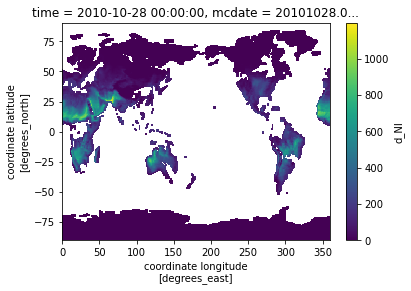

In [17]:
%%time
# these are the calculations that take forever!
# maybe it's not worth loading thse intermediate calculations into memory?

# Fates_fire constants
# Nesterov from EQ 5 Thonicke et al 2010:
fdi_a = 17.62
fdi_b = 243.12

yipsolon = (fdi_a * ds.temp) / (fdi_b + ds.temp) + np.log(ds.rh)
yipsolonSSP = (fdi_a * dsSSP.temp) / (fdi_b + dsSSP.temp) + np.log(dsSSP.rh)

# Standard met. formula
dewpoint = (fdi_b * yipsolon) / (fdi_a - yipsolon)
dewpointSSP = (fdi_b * yipsolonSSP) / (fdi_a - yipsolonSSP)

# follows Nesterov 1968.  Equation 5. Thonicke et al. 2010.
ds['d_NI'] = (ds.temp - dewpoint) * ds.temp  # .compute(skipna=True)
dsSSP['d_NI'] = (dsSSP.temp - dewpointSSP) * dsSSP.temp

# don't allow negative values
ds['d_NI'] = ds['d_NI'].where(ds['d_NI'] > 0, 0)
dsSSP['d_NI'] = dsSSP['d_NI'].where(dsSSP['d_NI'] > 0, 0)

# Reset when daily precip > 3 mm/day
ds['d_NI'] = ds['d_NI'].where(ds.PPT < 3, np.nan)  # .compute(skipna=True)
dsSSP['d_NI'] = dsSSP['d_NI'].where(dsSSP.PPT < 3, np.nan)  # .compute(skipna=True)
ds['d_NI'].isel(ens=0, time=300).plot();

### Accumulate Nesterov index over the fire season
####  Reset when daily precip > 3 mm/day (set d_NI to nan) 

In [18]:
# faster to select grid here
plat, plon = -13, 307.5
# 66.4, 209 Alaska
# 39,253    Crested Butte
# -13,307.5  Jackies amazon point
# 40, 270

In [19]:
# reset cumulative sum when nan crossed in dataset
# pandas examples here https://stackoverflow.com/questions/18196811/cumsum-reset-at-nan seems to work,
#    not so much for the numpy example...

# define function that calculates cumulative sum of d_NI that resets when nan
def runningSum(dIN):
    # make array to hold data
    result = dIN.copy()

    # loop over ens
    ## Can we avoind the ens loop here?
    for i in range(len(result[:])):
        v = pd.Series(dIN[i])
        cumsum = v.cumsum().fillna(method='pad')
        reset = -cumsum[v.isnull()].diff().fillna(cumsum)
        result[i, :] = v.where(v.notnull(), reset).cumsum()

    return result

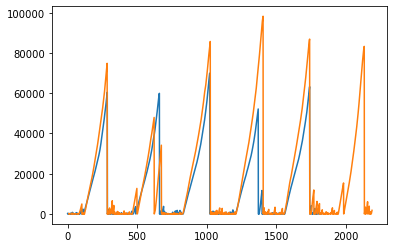

In [20]:
# test for a single grid
# data must be loaded into memory to work in the function above
tempIn = ds['d_NI'].sel(lon=plon, lat=plat, method='nearest').copy(deep=True).load()
tempInSSP = dsSSP['d_NI'].sel(lon=plon, lat=plat, method='nearest').copy(deep=True).load()

temp = runningSum(tempIn)
tempSSP = runningSum(tempInSSP)
plt.plot(temp[0, :])
plt.plot(tempSSP[0, :]);

In [21]:
# def running_sum_1d(data):
#     cumsum = data.cumsum().interpolate_na(dim='time', method='nearest')
#     reset = -cumsum[data.isnull()].diff(dim='time').fillna(cumsum)
#     data, reset = xr.broadcast(data, reset)
#     result = data.where(data.notnull(), reset).cumsum()
#     return result


def running_sum_np(data):
    v = pd.Series(data.copy())
    cumsum = v.cumsum().fillna(method='pad')
    reset = -cumsum[v.isnull()].diff().fillna(cumsum)
    result = v.where(v.notnull(), reset).cumsum()
    return result.values

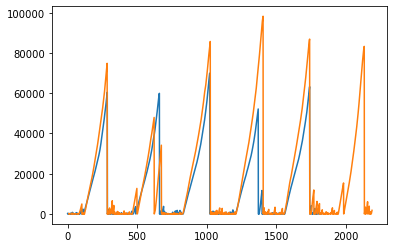

In [22]:
plt.plot(running_sum_np(tempIn.isel(ens=0)))
plt.plot(running_sum_np(tempInSSP.isel(ens=0)));

### Now try over full grid

~~Must load into memory first~~ 


In [23]:
# use apply_ufunc to broadcast running_sum_1d function globally
# Make sure the input dataset isn't chunked along the core `time` dimension
input_ds = ds.d_NI.chunk({'time': -1})

TEST = xr.apply_ufunc(
    running_sum_np,
    input_ds,
    input_core_dims=[['time']],
    output_core_dims=[["time"]],
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
    output_dtypes=[ds.d_NI.dtype],
)
TEST

<xarray.DataArray 'd_NI' (ens: 5, lat: 192, lon: 288, time: 1826)>
dask.array<transpose, shape=(5, 192, 288, 1826), dtype=float32, chunksize=(1, 192, 288, 1826), chunktype=numpy.ndarray>
Coordinates:
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat           (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    area          (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landfrac      (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landmask      (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    pftmask       (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nbedrock      (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
  * time          (time) object 2010-01-01 00:00:00 ... 2014-12-31 00:00:00
    mcdate        (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    mcsec         (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    mdcur         (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    mscur         (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    nstep         (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    date_written  (time) object dask.array<chunksize=(1826,), meta=np.ndarray>
    time_written  (time) object dask.array<chunksize=(1826,), meta=np.ndarray>
  * ens           (ens) int64 0 1 2 3 4
    gw            (lat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    P0            float64 1e+05
    ndbase        float64 0.0
    nsbase        float64 0.0
    nbdate        float64 1.85e+07
    nbsec         float64 0.0
    mdt           float64 1.8e+03
    date          (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    datesec       (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    ndcur         (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    nscur         (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    co2vmr        (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    ch4vmr        (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    n2ovmr        (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    nsteph        (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>

In [24]:
from distributed import wait

In [25]:
%%time
TEST = client.persist(TEST, retries=3)
wait(TEST)
TEST

CPU times: user 2.56 s, sys: 251 ms, total: 2.81 s
Wall time: 1min 35s


<xarray.DataArray 'd_NI' (ens: 5, lat: 192, lon: 288, time: 1826)>
dask.array<transpose, shape=(5, 192, 288, 1826), dtype=float32, chunksize=(1, 192, 288, 1826), chunktype=numpy.ndarray>
Coordinates:
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat           (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    area          (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landfrac      (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landmask      (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    pftmask       (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nbedrock      (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
  * time          (time) object 2010-01-01 00:00:00 ... 2014-12-31 00:00:00
    mcdate        (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    mcsec         (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    mdcur         (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    mscur         (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    nstep         (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    date_written  (time) object dask.array<chunksize=(1826,), meta=np.ndarray>
    time_written  (time) object dask.array<chunksize=(1826,), meta=np.ndarray>
  * ens           (ens) int64 0 1 2 3 4
    gw            (lat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    P0            float64 1e+05
    ndbase        float64 0.0
    nsbase        float64 0.0
    nbdate        float64 1.85e+07
    nbsec         float64 0.0
    mdt           float64 1.8e+03
    date          (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    datesec       (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    ndcur         (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    nscur         (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    co2vmr        (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    ch4vmr        (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    n2ovmr        (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>
    nsteph        (time) float64 dask.array<chunksize=(1826,), meta=np.ndarray>

### Can this be done more efficiently?  

DataArrayGroupBy, grouped over 'year' 
5 groups with labels 2010, 2011, 2012, 2013, 2014.
DataArrayResample, grouped over '__resample_dim__' 
5 groups with labels 2010-12-31, 00:00:00, ..., 201....


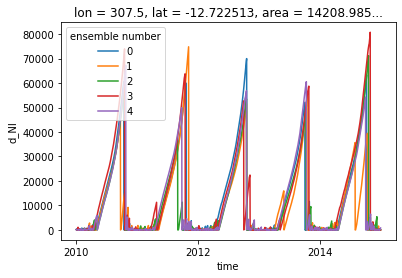

In [26]:
# quick look at the data
TEST.sel(lat=plat, lon=plon, method='nearest').plot(hue='ens')
print(TEST.groupby('time.year'))
print(TEST.resample(time='Y', skipna=True))  # .count(dim='time') )

## NI Fire Risk classification
* 0-300 minimal danger
* to 1000 moderate
* to 4000 high
* above 4000 extreme

In [27]:
%%time
# Ensemble mean of days / year with extreme fire risk
exCount = (
    TEST.where(TEST > 4000)
    .resample(time='Y', skipna=True)
    .count(dim='time')
    .mean(dim='ens')
    .compute(skipna=True)
)
exCountstd = (
    TEST.where(TEST > 4000)
    .resample(time='Y', skipna=True)
    .count(dim='time')
    .std(dim='ens')
    .compute(skipna=True)
)

CPU times: user 278 ms, sys: 19.4 ms, total: 297 ms
Wall time: 2.43 s


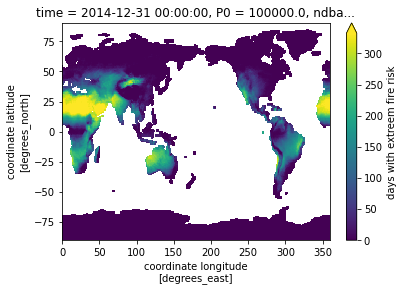

In [28]:
exCount.where(ds['PPT'].max(['time', 'ens']) > 0.0).isel(time=-1).plot(
    robust=True, cbar_kwargs={"label": "days with extreem fire risk"}
);

### Repeat with SSP data

In [29]:
input_dsSSP = dsSSP['d_NI'].chunk({'time': -1})
# use apply_ufunc to broadcast running_sum_np
TESTSSP = xr.apply_ufunc(
    running_sum_np,
    input_dsSSP,
    input_core_dims=[['time']],
    output_core_dims=[["time"]],
    vectorize=True,
    keep_attrs=True,
    dask="parallelized",
    output_dtypes=[dsSSP.d_NI.dtype],
)
TESTSSP

<xarray.DataArray 'd_NI' (ens: 5, lat: 192, lon: 288, time: 2191)>
dask.array<transpose, shape=(5, 192, 288, 2191), dtype=float32, chunksize=(1, 192, 288, 2191), chunktype=numpy.ndarray>
Coordinates:
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat           (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    area          (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landfrac      (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landmask      (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    pftmask       (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nbedrock      (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
  * time          (time) object 2095-01-01 00:00:00 ... 2100-12-31 00:00:00
    mcdate        (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    mcsec         (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    mdcur         (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    mscur         (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    nstep         (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    date_written  (time) object dask.array<chunksize=(2191,), meta=np.ndarray>
    time_written  (time) object dask.array<chunksize=(2191,), meta=np.ndarray>
  * ens           (ens) int64 0 1 2 3 4
    gw            (lat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    P0            float64 1e+05
    ndbase        float64 0.0
    nsbase        float64 0.0
    nbdate        float64 2.015e+07
    nbsec         float64 0.0
    mdt           float64 1.8e+03
    date          (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    datesec       (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    ndcur         (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    nscur         (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    co2vmr        (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    ch4vmr        (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    n2ovmr        (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    nsteph        (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>

In [30]:
%%time
TESTSSP = client.persist(TESTSSP, retries=3)
wait(TESTSSP)
TESTSSP

CPU times: user 2.05 s, sys: 210 ms, total: 2.26 s
Wall time: 1min 37s


<xarray.DataArray 'd_NI' (ens: 5, lat: 192, lon: 288, time: 2191)>
dask.array<transpose, shape=(5, 192, 288, 2191), dtype=float32, chunksize=(1, 192, 288, 2191), chunktype=numpy.ndarray>
Coordinates:
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat           (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    area          (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landfrac      (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landmask      (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    pftmask       (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nbedrock      (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
  * time          (time) object 2095-01-01 00:00:00 ... 2100-12-31 00:00:00
    mcdate        (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    mcsec         (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    mdcur         (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    mscur         (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    nstep         (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    date_written  (time) object dask.array<chunksize=(2191,), meta=np.ndarray>
    time_written  (time) object dask.array<chunksize=(2191,), meta=np.ndarray>
  * ens           (ens) int64 0 1 2 3 4
    gw            (lat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    P0            float64 1e+05
    ndbase        float64 0.0
    nsbase        float64 0.0
    nbdate        float64 2.015e+07
    nbsec         float64 0.0
    mdt           float64 1.8e+03
    date          (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    datesec       (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    ndcur         (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    nscur         (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    co2vmr        (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    ch4vmr        (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    n2ovmr        (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>
    nsteph        (time) float64 dask.array<chunksize=(2191,), meta=np.ndarray>

In [31]:
%%time
exCountSSP = (
    TESTSSP.where(TESTSSP > 4000)
    .resample(time='Y', skipna=True)
    .count(dim='time')
    .mean(dim='ens')
    .compute(skipna=True)
)
exCountSSPstd = (
    TESTSSP.where(TESTSSP > 4000)
    .resample(time='Y', skipna=True)
    .count(dim='time')
    .std(dim='ens')
    .compute(skipna=True)
)

CPU times: user 273 ms, sys: 16.4 ms, total: 289 ms
Wall time: 1.44 s


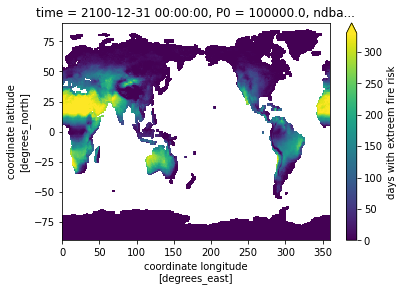

In [32]:
exCountSSP.where(dsSSP['PPT'].max(['time', 'ens']) > 0.0).isel(time=-1).plot(
    robust=True, cbar_kwargs={"label": "days with extreem fire risk"}
);

## Change days with in extreme fire risk 

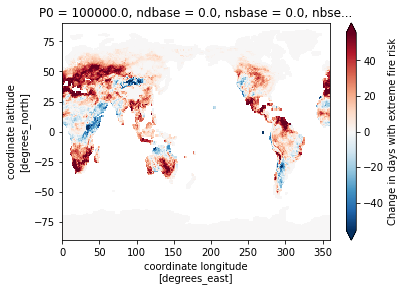

In [33]:
(exCountSSP.isel(time=-1) - exCount.isel(time=-1)).where(
    dsSSP['PPT'].max(['time', 'ens']) > 0
).plot(robust=True, cbar_kwargs={"label": "Change in days with extreme fire risk"});

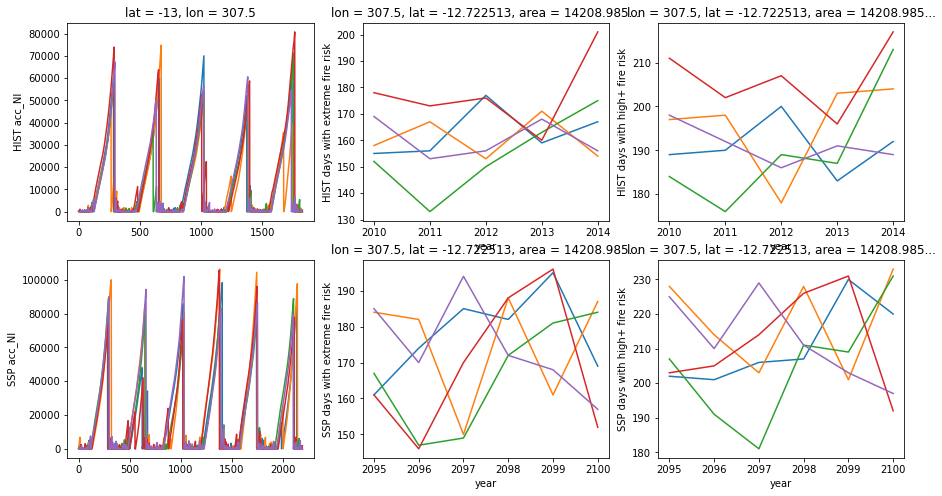

In [34]:
plt.figure(figsize=[15, 8])
plt.subplot(2, 3, 1)
plt.plot(temp.transpose('time', 'ens'))
plt.title('lat = ' + str(plat) + ', lon = ' + str(plon))
plt.ylabel('HIST acc_NI')

plt.subplot(2, 3, 2)
exCount = temp.where(temp > 4000).groupby('time.year').count(dim='time')
exCount.plot(hue='ens', add_legend=False)
plt.ylabel('HIST days with extreme fire risk')

plt.subplot(2, 3, 3)
hiCount = temp.where(temp > 1000).groupby('time.year').count(dim='time')
hiCount.plot(hue='ens', add_legend=False)
plt.ylabel('HIST days with high+ fire risk')

plt.subplot(2, 3, 4)
plt.plot(tempSSP.transpose('time', 'ens'))
plt.ylabel('SSP acc_NI')

plt.subplot(2, 3, 5)
exCount = tempSSP.where(tempSSP > 4000).groupby('time.year').count(dim='time')
exCount.plot(hue='ens', add_legend=False)
plt.ylabel('SSP days with extreme fire risk')

plt.subplot(2, 3, 6)
hiCount = tempSSP.where(tempSSP > 1000).groupby('time.year').count(dim='time')
hiCount.plot(hue='ens', add_legend=False)
plt.ylabel('SSP days with high+ fire risk');

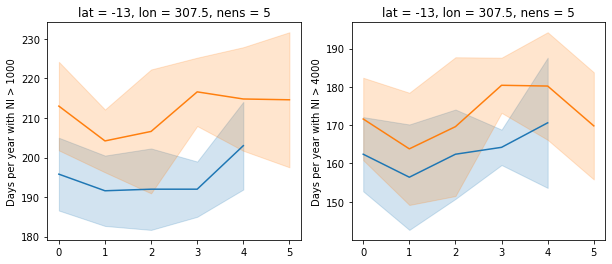

In [35]:
plt.figure(figsize=[10, 4])
minRisk = [1000, 4000]
for i in range(2):
    exCount_HIST = (
        temp.where(temp > minRisk[i]).groupby('time.year').count(dim='time').mean(dim='ens')
    )
    exCount_HISTsd = (
        temp.where(temp > minRisk[i]).groupby('time.year').count(dim='time').std(dim='ens')
    )
    exCount_SSP = (
        tempSSP.where(tempSSP > minRisk[i]).groupby('time.year').count(dim='time').mean(dim='ens')
    )
    exCount_SSPsd = (
        tempSSP.where(tempSSP > minRisk[i]).groupby('time.year').count(dim='time').std(dim='ens')
    )
    x1 = range(len(exCount_HIST.year))
    x2 = range(len(exCount_SSP.year))
    plt.subplot(1, 2, (i + 1))
    plt.plot(x1, exCount_HIST)
    plt.plot(x2, exCount_SSP)
    plt.fill_between(
        x1,
        exCount_HIST - exCount_HISTsd,
        exCount_HIST + exCount_HISTsd,
        alpha=0.2,
        color='tab:blue',
    )
    plt.fill_between(
        x2, exCount_SSP - exCount_SSPsd, exCount_SSP + exCount_SSPsd, alpha=0.2, color='tab:orange'
    )
    plt.title('lat = ' + str(plat) + ', lon = ' + str(plon) + ', nens = ' + str(nens))
    plt.ylabel('Days per year with NI > ' + str(minRisk[i]))

# plt.plot(exCount_SSP)

### Accumulated Nesterov fire danger index shows increases in the number of days per year with high or extreme fire danger in 2100, relative to 2000, 
- check for statistical significance

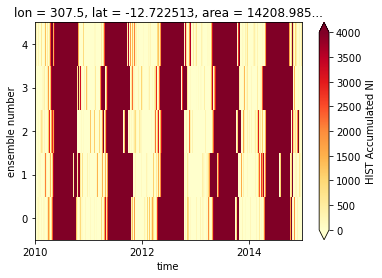

In [36]:
temp.plot(
    robust=True, cmap='YlOrRd', vmax=4000, vmin=0, cbar_kwargs={"label": "HIST Accumulated NI"}
);

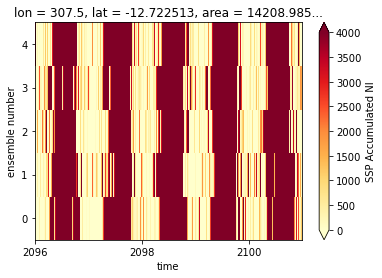

In [37]:
tempSSP.isel(time=slice(365, None)).plot(
    robust=True, cmap='YlOrRd', vmax=4000, vmin=0, cbar_kwargs={"label": "SSP Accumulated NI"}
);

### Maybe better illustrates seaonal cycle of fire risk, appears to have greater variability by 2100!

-----------------------
# Canadian fire weather model
### based on temp, wind, RH, precip & adjusted for monthly day length by latitude
- **fine fuel mositure code (ffmc)**: calc_ffmc(tempC, wind_kmhr, RH, precip_mm, ffmc_prev):
- **duff moisture code (dmc)**: calc_dmc(tmaxC, RH, precip_mm, dmc_prev, month, latitude):
- **drought code (dc)**: calc_dc(tmaxC, precip_mm, dc_prev, month, latitude):
- **initial spread index (isi)**: calc_isi(wind_kmhr,ffmc):
- **build up index (bui)**: calc_bui(dmc,dc):
- **fire weather index (fwi)**: calc_fwi(isi,bui) 

In [38]:
plat, plon = 66.4, 209
# 66.4, 209 Alaska
# 39,253    Crested Butte
# -13,307.5  Jackie's amazon point
# 40, 270
tempDS = ds.sel(ens=0, lon=plon, lat=plat, method='nearest').load()
tempSSP = dsSSP.sel(ens=0, lon=plon, lat=plat, method='nearest').load()

In [39]:
# tempDS.tmax.values[0]
tempDS['RHREFHT'] = tempDS.RHREFHT.where(tempDS.RHREFHT < 100, 100)
tempSSP['RHREFHT'] = tempSSP.RHREFHT.where(tempSSP.RHREFHT < 100, 100)
fwi.calc_ffmc(
    tempDS.tmax.values[3], tempDS.wind.values[3], tempDS.rh.values[3], tempDS.PPT.values[3], 80
)

82.61578121102278

In [40]:
# create arrays to store output
FWIvars = ['ffmc', 'dmc', 'dc', 'isi', 'bui', 'fwi']
for v in range(len(FWIvars)):
    tempDS[FWIvars[v]] = xr.DataArray(np.nan, coords=tempDS.tmax.coords)
    tempSSP[FWIvars[v]] = xr.DataArray(np.nan, coords=tempSSP.tmax.coords)

# loop over days to calculte FWI
for i in tqdm(range(len(tempDS.tmax))):
    # set initial values for
    if i == 0:
        ffmc_prev, ffmc_ssp = 80, 80
        dmc_prev, dmc_ssp = 6, 6
        dc_prev, dc_ssp = 15, 15
    else:
        ffmc_prev, ffmc_ssp = tempDS['ffmc'].data[i - 1], tempSSP['ffmc'].data[i - 1]
        dmc_prev, dmc_ssp = tempDS['dmc'].data[i - 1], tempSSP['dmc'].data[i - 1]
        dc_prev, dc_ssp = tempDS['dc'].data[i - 1], tempSSP['dc'].data[i - 1]

    # calc_ffmc(tempC, wind_kmhr, RH, precip_mm, ffmc_prev):
    tempDS.ffmc[i] = fwi.calc_ffmc(
        tempDS.tmax.data[i],
        tempDS.wind.data[i],
        tempDS.RHREFHT.data[i],
        tempDS.PPT.data[i],
        ffmc_prev,
    )
    tempSSP.ffmc[i] = fwi.calc_ffmc(
        tempSSP.tmax.data[i],
        tempSSP.wind.data[i],
        tempSSP.RHREFHT.data[i],
        tempSSP.PPT.data[i],
        ffmc_ssp,
    )
    # calc_dmc(tmaxC, RH, precip_mm, dmc_prev, month, latitude):
    tempDS.dmc[i] = fwi.calc_dmc(
        tempDS.tmax.data[i],
        tempDS.RHREFHT.data[i],
        tempDS.PPT.data[i],
        dmc_prev,
        tempDS['time.month'][i],
        tempDS['lat'],
    )
    tempSSP.dmc[i] = fwi.calc_dmc(
        tempSSP.tmax.data[i],
        tempSSP.RHREFHT.data[i],
        tempSSP.PPT.data[i],
        dmc_ssp,
        tempDS['time.month'][i],
        tempDS['lat'],
    )
    # calc_dc(tmaxC, precip_mm, dc_prev, month, latitude):
    tempDS.dc[i] = fwi.calc_dc(
        tempDS.tmax.data[i], tempDS.PPT.data[i], dc_prev, tempDS['time.month'][i], tempDS['lat']
    )
    tempSSP.dc[i] = fwi.calc_dc(
        tempSSP.tmax.data[i], tempSSP.PPT.data[i], dc_ssp, tempDS['time.month'][i], tempDS['lat']
    )
# calc_isi(wind_kmhr,ffmc):
tempDS.isi.data = fwi.calc_isi(tempDS.wind, tempDS.ffmc)
tempSSP.isi.data = fwi.calc_isi(tempSSP.wind, tempSSP.ffmc)
# calc_bui(dmc,dc):
tempDS['bui'].data = fwi.calc_bui(tempDS.dmc, tempDS.dc)
tempSSP['bui'].data = fwi.calc_bui(tempSSP.dmc, tempSSP.dc)
# calc_fwi(isi,bui):
tempDS['fwi'].data = fwi.calc_fwi(tempDS.isi, tempDS.bui)
tempSSP['fwi'].data = fwi.calc_fwi(tempSSP.isi, tempSSP.bui)

  0%|          | 0/1826 [00:00<?, ?it/s]

/glade/work/abanihi/opt/miniconda/envs/lens-py/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in calc_bui
  result_data = func(*input_data)


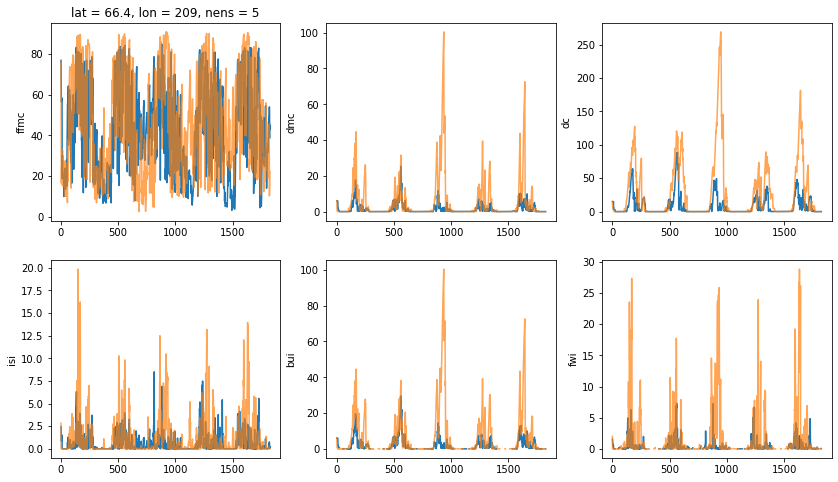

In [41]:
plt.figure(figsize=[14, 8])
for i in range(len(FWIvars)):
    plt.subplot(2, 3, (i + 1))
    if i == 0:
        plt.title('lat = ' + str(plat) + ', lon = ' + str(plon) + ', nens = ' + str(nens))
    plt.plot(tempDS[FWIvars[i]])
    plt.plot(tempSSP[FWIvars[i]], alpha=0.7)
    plt.ylabel(FWIvars[i]);

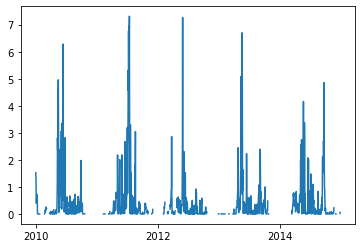

In [42]:
plt.plot(tempDS.time, tempDS['fwi'])
# plt.plot(tempSSP['fwi'])

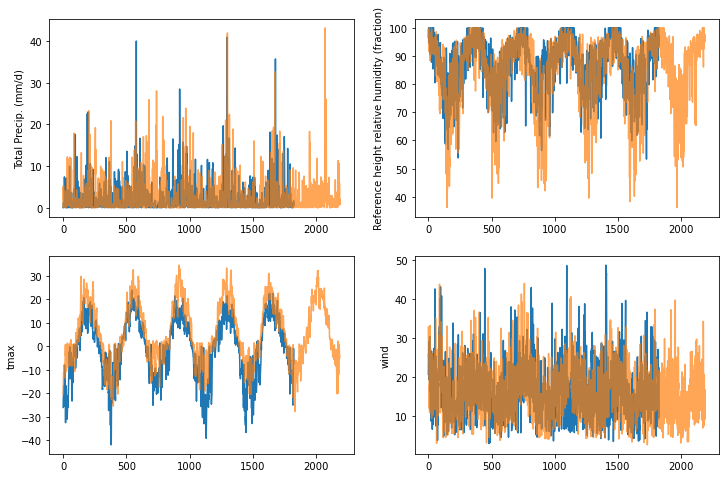

In [43]:
atmVARS = ['PPT', 'RHREFHT', 'tmax', 'wind']
plt.figure(figsize=[12, 8])

for i in range(len(atmVARS)):
    plt.subplot(2, 2, (i + 1))
    plt.plot(tempDS[atmVARS[i]])
    plt.plot(tempSSP[atmVARS[i]], alpha=0.7)
    if i < 2:
        plt.ylabel(
            tempDS[atmVARS[i]].attrs['long_name'] + ' (' + tempDS[atmVARS[i]].attrs['units'] + ')'
        )
    else:
        plt.ylabel(atmVARS[i]);

In [2]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark --updated --date --iversions --gitrepo --gitbranch --githash --python

Last updated: 2021-02-24

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.20.0

Git hash: f2c26d9d6bf7afdb0315409c0a55dc546a7dc2b7

Git repo: git@github.com:andersy005/cesm-lens.git

Git branch: optimizations

pandas    : 1.2.2
numpy     : 1.20.1
numba     : 0.52.0
matplotlib: 3.3.4
dask      : 2021.2.0
xarray    : 0.16.2
cftime    : 1.4.1
scipy     : 1.6.0

